<a href="https://colab.research.google.com/github/c3qian/Hello-Chao/blob/master/OCR_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Recurrent Neural Network (CRNN) for OCR


Steps for OCR:

1. Preprocessing Data
2. Creating Network Architecture(CTC loss function)
3. Training Model
4. Test Model

###Import

In [0]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

#ignore warnings in the output
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from glob import glob
 
import matplotlib.pyplot as plt 

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1675543967761075537
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13732209531282500332
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4678048943322583305
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18316557315682751779
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


### Preprocessing

1. Download and unzip the dataset into a folder
2. Preprocess the data: both inputs and outputs

Input:

*   Read the images and convert them into gray-scale images(why?)
*   Reshape each image to size (128,32) (why?)
*   Expand the dimension of the image from (128,32) to (128,32,1) (why?)
*   Normalize the image pixel values by dividing it with 255

Output:

*   Read the image file names as the labels of that image
*   Encode word into digits using a map (‘a’:0, ‘b’:1 …….. ‘z’:26 ......) e.g.  "aabb" -> [0,0,1,1]
*   Find the maximum length among all words and pad every label to be the same size(max size) 



In [0]:
!rm -rf dataset dataset.zip __MACOSX
# small dataset
!wget https://transfer.sh/MrGxw/dataset.zip
# large dataset
#!wget https://transfer.sh/NwLvB/dataset.zip
!unzip -qq dataset.zip


--2019-07-20 20:31:15--  https://transfer.sh/MrGxw/dataset.zip
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65265888 (62M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  62.24M  12.3MB/s    in 6.6s    

2019-07-20 20:31:24 (9.45 MB/s) - ‘dataset.zip’ saved [65265888/65265888]



In [0]:
# char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

char_list = string.ascii_letters+string.digits
print('char_list:',char_list)
print('total length:', len(char_list))
 

# every word is encoded as a list of digits
# the digit for each character is represented by the index
# e.g. aabb -> [0,0,1,1], index of a is 0, index of b is 1

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

char_list: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
total length: 62


In [0]:
path = 'dataset/'
 
#lists for training dataset
train_x = []
train_y = []
train_x_len = []
train_y_len = []
orig_y = []
 
#lists for validation dataset
val_x = []
val_y = []
val_x_len = []
val_y_len = []
val_orig_y = []
 
max_label_len = 0
 
flag = 0
 
for i, f_name in enumerate(glob(os.path.join(path,'*/*/*.jpg'))):
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(f_name), cv2.COLOR_BGR2GRAY)   
    # convert each image of shape (32, 128, 1)

    img = cv2.resize(img,(128,32))
    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img/255.

    # get the text from the image
    txt = os.path.basename(f_name).split('_')[1]

    # compute maximum length of the text
    if len(txt) > max_label_len:
        max_label_len = len(txt)

    # split the data into validation and training dataset as 10% and 90% respectively
    if i%10 == 0:     
        val_x.append(img)
        val_y.append(encode_to_labels(txt))
        val_x_len.append(31)
        val_y_len.append(len(txt))
        val_orig_y.append(txt)  
    else:
        train_x.append(img)
        train_y.append(encode_to_labels(txt)) 
        train_x_len.append(31)
        train_y_len.append(len(txt))
        orig_y.append(txt)



Number of training data: 28717
Number of validation data: 3191
Label value:  [16, 20, 14, 19, 0, 1, 11, 4]
Raw Label value:  quotable


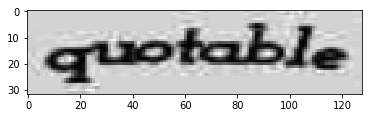

In [0]:
print('Number of training data:',len(train_x))
print('Number of validation data:',len(val_x))

plt.imshow(train_x[0][:,:,0], cmap='gray')
print('Label value: ',train_y[0])
print('Raw Label value: ', orig_y[0])

In [0]:

  
# pad each output label to maximum text length
# use "post" padding
# this is not zero padding, we want to pad a specific value: len(char_list)
 
train_padded_y = pad_sequences(train_y, maxlen=max_label_len, padding='post', value = len(char_list))
val_padded_y = pad_sequences(val_y, maxlen=max_label_len, padding='post', value = len(char_list))

### Network Archtecture

Paper link: (https://arxiv.org/pdf/1507.05717.pdf)

1. Input shape (32,128,1)
2. Use CNN to produce feature map
5. Make feature map compatible with LSTM layer.
6. Use two Bidirectional LSTM layers each of which has 128 units. 

In [0]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# Conv2D: 64 filters, (3,3) kernels, rectified unit, use "same" padding
# Pooling: (2,2) size, stride 2
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer, 
# blog: https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
# reduce the dimension
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
# we want to return sequences, not the last output
# use dropout 0.2
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
# our final output has [len(char_list)+1] classes
# we need to use softmax as the activation function
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [0]:

act_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 32, 256)        590080    
__________

### Loss Function

CTC Details: (https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

In [0]:
### CTC examples https://distill.pub/2017/ctc/

labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [0]:
# convert list to np array
train_x = np.array(train_x)
train_x_len = np.array(train_x_len)
train_y_len = np.array(train_y_len)

val_x = np.array(val_x)
val_x_len = np.array(val_x_len)
val_y_len = np.array(val_y_len)

### train the Model

In [0]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
# this is a keras functionality, after each epoch if we find the current model 
# has the lowest loss so far, we will save the model
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [0]:
batch_size = 256
epochs = 10
# actually start the training
model.fit(x=[train_x, train_padded_y, train_x_len, train_y_len], y=np.zeros(len(train_x)), batch_size=batch_size, epochs = epochs, validation_data = ([val_x, val_padded_y, val_x_len, val_y_len], [np.zeros(len(val_x))]), verbose = 1, callbacks = callbacks_list)

Train on 145732 samples, validate on 7671 samples
Epoch 1/10
145732/145732 [==============================] - 482s 3ms/step - loss: 28.1754 - val_loss: 26.9775

Epoch 00001: val_loss improved from inf to 26.97753, saving model to best_model.hdf5
Epoch 2/10
145732/145732 [==============================] - 464s 3ms/step - loss: 10.0044 - val_loss: 5.6280

Epoch 00002: val_loss improved from 26.97753 to 5.62796, saving model to best_model.hdf5
Epoch 3/10
145732/145732 [==============================] - 463s 3ms/step - loss: 4.4299 - val_loss: 4.0441

Epoch 00003: val_loss improved from 5.62796 to 4.04407, saving model to best_model.hdf5
Epoch 4/10
145732/145732 [==============================] - 463s 3ms/step - loss: 3.5185 - val_loss: 3.6355

Epoch 00004: val_loss improved from 4.04407 to 3.63553, saving model to best_model.hdf5
Epoch 5/10
145732/145732 [==============================] - 464s 3ms/step - loss: 3.0710 - val_loss: 3.2557

Epoch 00005: val_loss improved from 3.63553 to 3.255

### Test the Model

In [0]:
# Download a trained model
!rm best_model.hdf5
!wget https://transfer.sh/11ClXx/best_model.hdf5

--2019-07-20 20:32:35--  https://transfer.sh/11ClXx/best_model.hdf5
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79536948 (76M) [application/octet-stream]
Saving to: ‘best_model.hdf5’

best_model.hdf5     100%[===================>]  75.85M  12.7MB/s    in 7.5s    

2019-07-20 20:32:44 (10.1 MB/s) - ‘best_model.hdf5’ saved [79536948/79536948]



In [0]:

# load the saved best model weights
act_model.load_weights('best_model.hdf5')
 
# predict outputs on validation images
prediction = act_model.predict(val_x[:10])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

# see the results
i = 0
for x in out:
    print("original_text =  ", val_orig_y[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1
print(out)
print(val_orig_y)

original_text =   seamy
predicted text = D

original_text =   chauffeured
predicted text = CMAUFTIEUAES

original_text =   Ellipsis
predicted text = Ellipsis

original_text =   CONCETTA
predicted text = CONCETTS

original_text =   Teamwork
predicted text = Teamwork

original_text =   sours
predicted text = sours

original_text =   expostulate
predicted text = expostulate

original_text =   SQUEEGEES
predicted text = SQUEEGEES

original_text =   scleroses
predicted text = scleroses

original_text =   PERTLY
predicted text = PERTLY

[[29 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [28 38 26 46 31 45 34 30 46 26 30 44]
 [30 11 11  8 15 18  8 18 -1 -1 -1 -1]
 [28 40 39 28 30 45 45 44 -1 -1 -1 -1]
 [45  4  0 12 22 14 17 10 -1 -1 -1 -1]
 [18 14 20 17 18 -1 -1 -1 -1 -1 -1 -1]
 [ 4 23 15 14 18 19 20 11  0 19  4 -1]
 [44 42 46 30 30 32 30 30 44 -1 -1 -1]
 [18  2 11  4 17 14 18  4 18 -1 -1 -1]
 [41 30 43 45 37 50 -1 -1 -1 -1 -1 -1]]
['seamy', 'chauffeured', 'Ellipsis', 'CONCETTA', 'Teamwork', 'sours', 'e

In [0]:
'''
We want to know the accuracy [the number of correct/total number]
 1. if the predicted text == truth label, we count as 1
 2. otherwise, we count as 0
e.g.
If we have a word "Theword",
then the predicted text:
"Theword" -> 1
"Theward" -> 0
'''
prediction = act_model.predict(val_x)
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

count = 0
for i in range(len(out)):
  new =[]
  for char in val_orig_y[i]:
    new.append(char_list.index(char))
  length = len(new)
  
  if (out[i][:length] == new).all():
    count +=1
  #print(new)
  #print(out[i])
    
print('Accuracy:', count/len(val_orig_y))
#print(out)


Accuracy: 0.7815731745534316


# Documents Scanner

Steps:


1.   Take a picture
2.   Perform word or line detection
3.   Use OCR model to do predictions on every bounding boxes
4.   Visualize the result



###Upload a picture

In [0]:
from google.colab import files
files.upload()

Saving 1.png to 1.png


{'1.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03p\x00\x00\x01\r\x08\x06\x00\x00\x00N\xc9\x87\xe1\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00\x009tEXtSoftware\x00matplotlib version 3.0.3, http://matplotlib.org/\x9d\x0b\xab\xa3\x00\x00 \x00IDATx\x9c\xec}y\x94T\xc5\xf5\xff\xe7\xbd^\xa6g\x06\x90\x1dQ\x16\x15\x05\x13P\x14\x08AD\xa3QLH\xd0\x18w\x14\x8c1\xee\xc6\x85\xb8\xe0\x12\x15O\x8c1n\x18\xfcE\x10\x8c\x88Fc4\xee\x0b\xa8Q\t\xb2\x08\x02A\t*K\x08\x88,\xb290\xd3\xfbR\xbf?\x9aO\xf5}\x8f\xee\x9e\x9e\x9e\xe9j8\xdf\xaes\xe6\xccL\xf7{U\xf5\xa9{\xeb~\xee\xbdU\xaf\x9e\xa5\x94B\xa5TJ\xa5TJ\xa5TJ\xa5TJ\xa5TJ\xa5TJ\xa5\xec\xfd\xc5.w\x07*\xa5R*\xa5R*\xa5R*\xa5R*\xa5R*\xa5R*\xa5\xb0R\t\xe0*\xa5R*\xa5R*\xa5R*\xa5R*\xa5R*\xa5R\xf6\x91R\t\xe0*\xa5R*\xa5R*\xa5R*\xa5R*\xa5R*\xa5R\xf6\x91R\t\xe0*\xa5R*\xa5R*\xa5R*\xa5R*\xa5R*\xa5R\xf6\x91R\t\xe0*\xa5R*\xa5R*\xa5R*\xa5R*\xa5R*\xa5R\xf6\x91R\t\xe0*\xa5R*\xa5R*\xa5R*\xa5R*\xa5

###Detection using open source

In [0]:
#Intall libs
#https://gitlab.gnome.org/World/OpenPaperwork/pyocr
!apt-get install tesseract-ocr
!pip install pyocr
!pip install wand
!pip install pillow
!apt-get install libmagickwand-dev
!apt-get install freetype imagemagick


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagickwand-dev is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.7).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package freetype


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from wand.image import Image
from PIL import Image
import pyocr
import pyocr.builders
import io


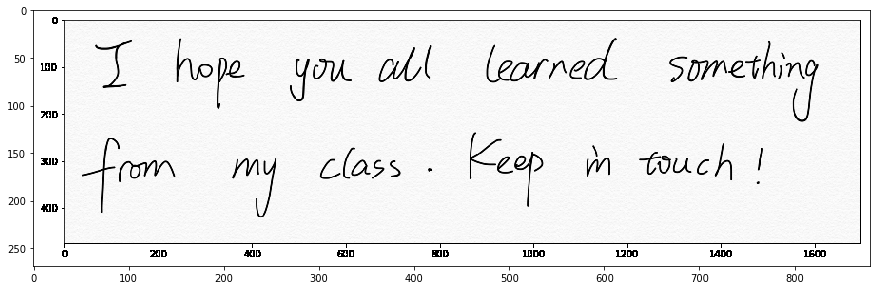

In [0]:
img_path = '1.png'
#where is the image you uploaded
image = cv2.imread(img_path,0)
plt.figure(figsize=(15,15))
plt.imshow(image,cmap='gray')

In [0]:
tool = pyocr.get_available_tools()[0]
lang = tool.get_available_languages()[0] #english

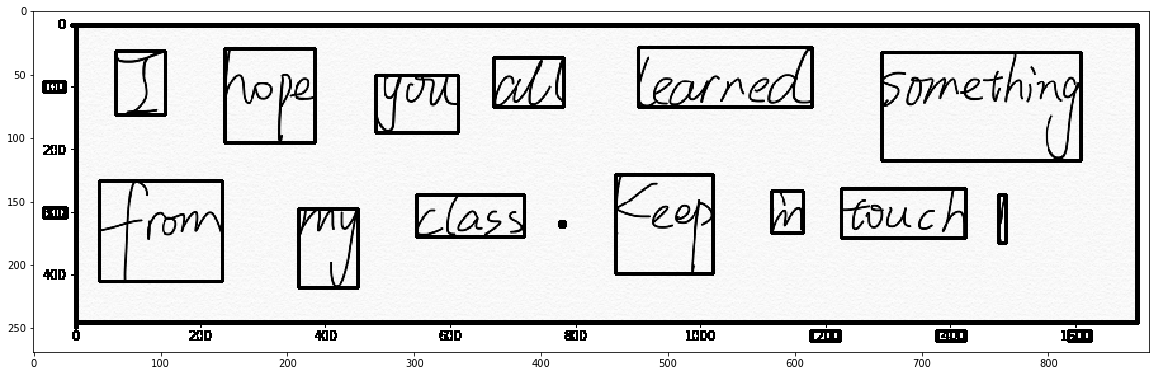

In [0]:
### Detection of words
image = cv2.imread(img_path,0)
word_boxes = tool.image_to_string(
    Image.open(img_path),
    lang=lang,
    builder=pyocr.builders.WordBoxBuilder()
)
for box in word_boxes:
    cv2.rectangle(image, box.position[0], box.position[1], color=(0,0,255), thickness=2)
plt.figure(figsize=(20,20))
plt.imshow(image,cmap='gray')

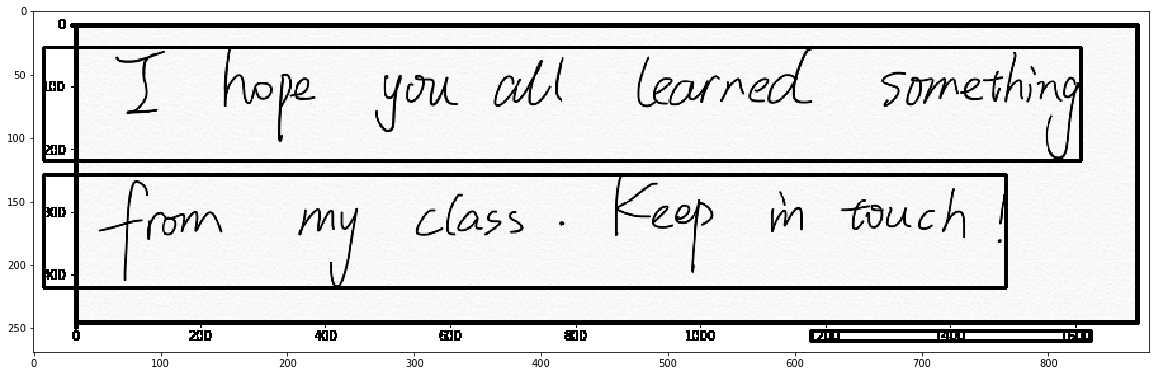

In [0]:
### Detection of lines
image = cv2.imread(img_path,0)
line_boxes = tool.image_to_string(
    Image.open(img_path), lang=lang,
    builder=pyocr.builders.LineBoxBuilder()
)
for box in line_boxes:
    cv2.rectangle(image, box.position[0], box.position[1], color=(0,0,255), thickness=2)
plt.figure(figsize=(20,20))
plt.imshow(image,cmap='gray')



###Prediction by our OCR model

In [0]:
'''
Now we want to use the OCR model to predict each boxes
- We should use word_boxes instead of line_boxes(Why?)
- We should convert the structure of word_boxes to be the input of OCR model
Requirements:
1. Should crop the box from the original image
2. The crop should be resized to (128, 32, 1)
3. The crop Should be normalized to 0-1
'''

boxes_x = []
for box in word_boxes:
  #print(box)
  pos = box.position
  #print(pos)
  crop = image[pos[0][1]: pos[1][1], pos[0][0]:pos[1][0]]
  crop = cv2.resize(crop,(128,32))/255
  crop = np.expand_dims(crop , axis = 2)
  print(crop.shape)
  boxes_x.append(crop)


(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)


In [0]:
# Once you have the input of OCR model ready
# Use functions to the predicted result:
# 1. act_model.predict
# 2. K.get_value(K.ctc_decode(...))

# Note: K.get_value returns a list of list of indexes, each index corresponds to the character in char_list
# e.g. you should use char_list[index] to recover the characters
#      [0, 1, 0, -1] -> 'a','b','a',blank
#takes in a number of boxes, and put it in a array.
prediction = act_model.predict(np.array(boxes_x))
words = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])


In [0]:
words

array([[28, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [28, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [46,  5, 11,  4, 13, -1, -1, -1, -1, -1, -1],
       [45, 44, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 7, 20, 21,  4, -1, -1, -1, -1, -1, -1, -1],
       [50, 26, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [28, 46, 37, -1, -1, -1, -1, -1, -1, -1, -1],
       [11,  4,  0, 17, 13,  4,  3, -1, -1, -1, -1],
       [18, 14, 12, 17,  4, 17, 19,  7,  8, 13,  6],
       [33, 26, 37, 30, -1, -1, -1, -1, -1, -1, -1],
       [18,  5,  2, 20, 13, 13, -1, -1, -1, -1, -1],
       [34, 37, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 2, 11, 14, 18, 18, -1, -1, -1, -1, -1, -1],
       [43, 18, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [17,  4,  2,  5, -1, -1, -1, -1, -1, -1, -1],
       [21, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [19, 14, 20,  2,  7, -1, -1, -1, -1, -1, -1],
       [38, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [28, -1, -1, -1, -1, -1, -1, -1, -1, -1

###Visualize the result

In [0]:
len(words)

23

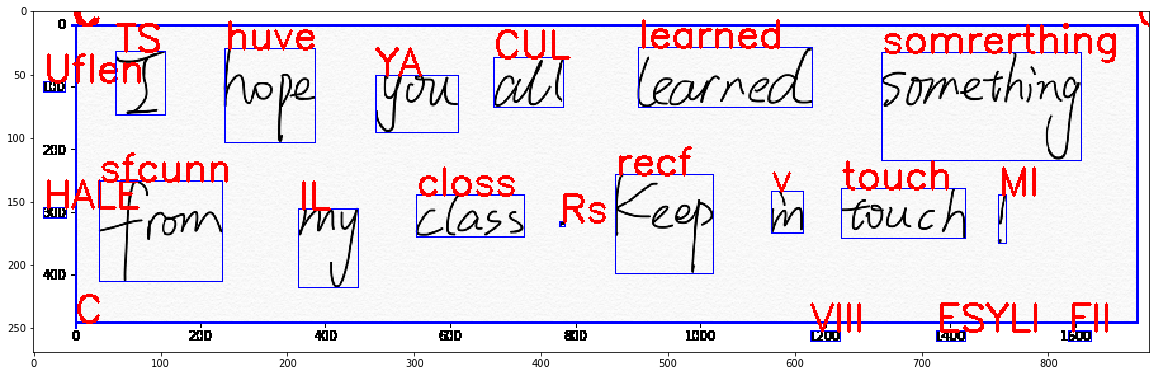

In [0]:
# Now we want to visualize all the boxes and predicted text on the original image
# Hint:
# use cv2.rectangle to draw box
# use cv2.putText to draw text

image = cv2.imread(img_path)


for i in range(len(words)):
    box = word_boxes[i]

    word = words[i]
    my_word = ''
    for j in word:      
      if j != -1:
        my_word += char_list[j]
     
    cv2.rectangle(image, box.position[0], box.position[1], color=(0,0,255), thickness=1)
    cv2.putText(image,my_word,box.position[0],0,fontScale=1,color=(255,0,0),thickness=2)
plt.figure(figsize=(20,20))
plt.imshow(image,cmap='gray')

###Output raw text(optional)

e.g. The example image should give output:

I hope you all learned something

from my class. Keep in touch !